## Splitting up the Tile Data into `[Tile]`

In [1]:
from decode import decode_A50, decode_A50_downhill, decode_F6P, decode_tile
import matplotlib.pyplot as plt
from sync import syncTile, splitTileIntoDownhillTracks
from tile import Tile
from track import Track

a50 = decode_A50_downhill("../DATA/2023_12_31/Mt St Sauveur/A50/Mount St Sauveur PATCHED.csv")
a50_all = decode_A50("../DATA/2023_12_31/Mt St Sauveur/A50/Mount St Sauveur PATCHED.csv")
f6p = decode_F6P("../DATA/2023_12_31/Mt St Sauveur/F6P/13306856415_ACTIVITY.csv")
tile = decode_tile("../DATA/2023_12_31/Mt St Sauveur/Tile/SENS000.CSV")

In [2]:
stitched_f6p_time = []
stitched_f6p_alt = []

for track in f6p: 
    stitched_f6p_time += track.time
    stitched_f6p_alt += track.alt


In [3]:
tile_sync = syncTile(
    tile=tile,
    truth=a50_all,
    printOutput=True,
    alt_step=0.25,
    min_alt_start=42,
    max_alt_search=46)

3%
6%
10%
13%
16%
19%
23%
26%
29%
32%
35%
39%
42%
45%
48%
52%
55%
58%
61%
65%
68%
71%
74%
77%
81%
84%
87%
90%
94%
97%
Timestamp offset: 100
Altitude offset: 42.5


In [4]:
# get the first timestamps for every f6p run
ts_splits = [[track.time[0], track.time[-1]] for track in f6p]

In [5]:
def splitTile(tile_sync: Tile, ts_splits: list[list]):
    # get indices in tile_sync that match these timestamps
    tile_start_idxs = [tile_sync.time.index(split[0]) for split in ts_splits]
    tile_stop_idxs = [tile_sync.time.index(split[1]) for split in ts_splits]

    # split by these timestamps into [Tile]
    tile_runs = []
    for i in range(len(tile_start_idxs)):
        tile_runs.append(
            Tile(
                time=tile_sync.time[tile_start_idxs[i]:tile_stop_idxs[i]],
                ax=tile_sync.ax[tile_start_idxs[i]:tile_stop_idxs[i]],
                ay=tile_sync.ay[tile_start_idxs[i]:tile_stop_idxs[i]],
                az=tile_sync.az[tile_start_idxs[i]:tile_stop_idxs[i]],
                gx=tile_sync.gx[tile_start_idxs[i]:tile_stop_idxs[i]],
                gy=tile_sync.gy[tile_start_idxs[i]:tile_stop_idxs[i]],
                gz=tile_sync.gz[tile_start_idxs[i]:tile_stop_idxs[i]],
                mx=tile_sync.mx[tile_start_idxs[i]:tile_stop_idxs[i]],
                my=tile_sync.my[tile_start_idxs[i]:tile_stop_idxs[i]],
                mz=tile_sync.mz[tile_start_idxs[i]:tile_stop_idxs[i]],
                pres=tile_sync.pres[tile_start_idxs[i]:tile_stop_idxs[i]],
                temp=tile_sync.temp[tile_start_idxs[i]:tile_stop_idxs[i]],
                hum=tile_sync.hum[tile_start_idxs[i]:tile_stop_idxs[i]],
                alt=tile_sync.alt[tile_start_idxs[i]:tile_stop_idxs[i]]
            )
        )

    print(len(tile_runs))
    return tile_runs

In [6]:
stitched_tile_runs_time = []
stitched_tile_runs_alt = []

for track in splitTile(tile_sync, ts_splits): 
    stitched_tile_runs_time += track.time
    stitched_tile_runs_alt += track.alt


35


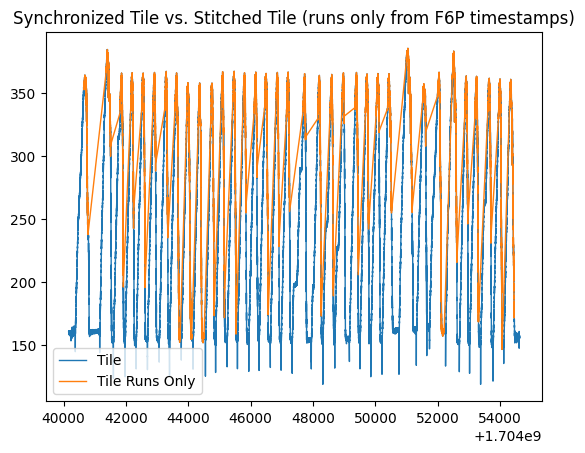

In [7]:
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(tile_sync.time, tile_sync.alt, label='Tile')
ax.plot(stitched_tile_runs_time, stitched_tile_runs_alt, label='Tile Runs Only')
ax.set_title('Synchronized Tile vs. Stitched Tile (runs only from F6P timestamps)', wrap=True)
ax.legend()
plt.show()

Well that isn't great... A constant shift from the A50 to the Garmin F6P data would be beneficial.

## Calculating the Garmin Timestamp Shift (from the A50)

In [8]:
stitched_a50_time = []
stitched_a50_alt = []

for track in a50_all: 
    stitched_a50_time += track.time
    stitched_a50_alt += track.alt

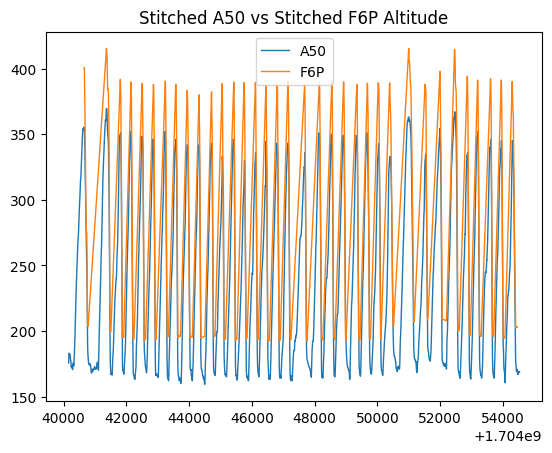

In [9]:
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(stitched_a50_time, stitched_a50_alt, label='A50')
ax.plot(stitched_f6p_time, stitched_f6p_alt, label='F6P')
ax.set_title('Stitched A50 vs Stitched F6P Altitude', wrap=True)
ax.legend()
plt.show()

Track the difference between the avg start & stop timestamps for the Downhill tracks:

In [10]:
ts_splits_f6p = [[track.time[0], track.time[-1]] for track in f6p]
ts_splits_a50 = [[track.time[0], track.time[-1]] for track in a50]

start_avg = 0
stop_avg = 0
for i in range(len(ts_splits_f6p)):
    start_diff = abs(ts_splits_f6p[i][0] - ts_splits_a50[i][0])
    stop_diff = abs(ts_splits_f6p[i][1] - ts_splits_a50[i][1])
    print('start:', start_diff)
    print('stop:', stop_diff)
    start_avg += start_diff
    stop_avg += stop_diff

start_avg /= len(ts_splits_f6p)
stop_avg /= len(ts_splits_f6p)

print('avg:')
print(start_avg)
print(stop_avg)

start: 5.0
stop: 4.0
start: 20.0
stop: 15.0
start: 16.0
stop: 19.0
start: 6.0
stop: 21.0
start: 15.0
stop: 43.0
start: 10.0
stop: 42.0
start: 16.0
stop: 12.0
start: 6.0
stop: 8.0
start: 6.0
stop: 81.0
start: 23.0
stop: 103.0
start: 19.0
stop: 26.0
start: 5.0
stop: 14.0
start: 8.0
stop: 35.0
start: 7.0
stop: 17.0
start: 13.0
stop: 3.0
start: 13.0
stop: 44.0
start: 8.0
stop: 34.0
start: 11.0
stop: 25.0
start: 15.0
stop: 3.0
start: 5.0
stop: 25.0
start: 8.0
stop: 26.0
start: 5.0
stop: 7.0
start: 11.0
stop: 9.0
start: 12.0
stop: 4.0
start: 4.0
stop: 5.0
start: 1.0
stop: 33.0
start: 26.0
stop: 18.0
start: 17.0
stop: 15.0
start: 32.0
stop: 20.0
start: 10.0
stop: 42.0
start: 2.0
stop: 11.0
start: 1.0
stop: 39.0
start: 24.0
stop: 8.0
start: 6.0
stop: 38.0
start: 3.0
stop: 10.0
avg:
11.114285714285714
24.542857142857144


In [11]:
# get the first timestamps for every f6p run
ts_splits = [[track.time[0] - round(start_avg), track.time[-1] + round(stop_avg)] for track in f6p]

tile_runs = splitTile(tile_sync, ts_splits)

35


In [12]:
stitched_tile_runs_time = []
stitched_tile_runs_alt = []

for track in tile_runs: 
    stitched_tile_runs_time += track.time
    stitched_tile_runs_alt += track.alt


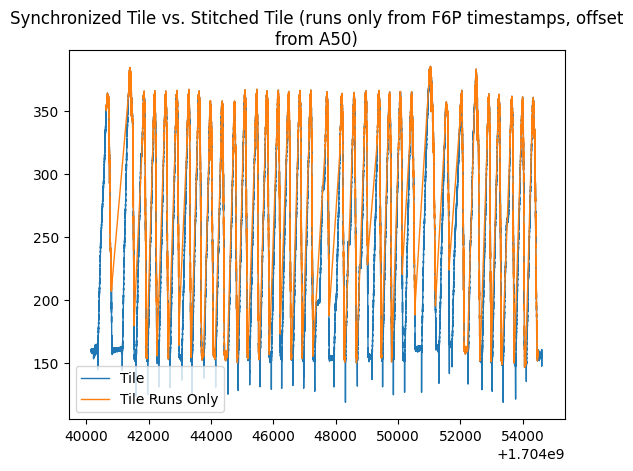

In [13]:
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(tile_sync.time, tile_sync.alt, label='Tile')
ax.plot(stitched_tile_runs_time, stitched_tile_runs_alt, label='Tile Runs Only')
ax.set_title('Synchronized Tile vs. Stitched Tile (runs only from F6P timestamps, offset from A50)', wrap=True)
ax.legend()
plt.show()

## As a Function `splitTileIntoDownhillTracks()`

In [37]:
stitched_tile_runs_time = []
stitched_tile_runs_alt = []

tile_runs = splitTileIntoDownhillTracks(
    tile_sync,
    f6p,
    a50,
    printOutput=True,
    start_offset=False)

for track in tile_runs: 
    stitched_tile_runs_time += track.time
    stitched_tile_runs_alt += track.alt

Avgerage starting and stopping indices:
11
25


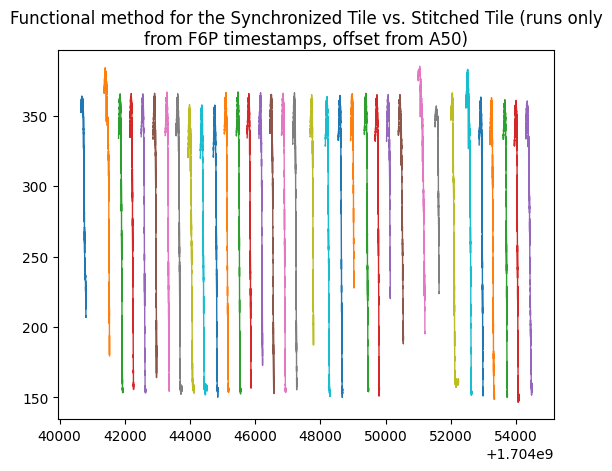

In [38]:
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
for i in range(len(tile_runs)): ax.plot(tile_runs[i].time, tile_runs[i].alt, label=['Tile Run', i])
ax.set_title('Functional method for the Synchronized Tile vs. Stitched Tile (runs only from F6P timestamps, offset from A50)', wrap=True)
plt.show()

In [39]:
def plotAltAcc(track: Tile):
    plt.rc('lines', linewidth=1)
    _, ax = plt.subplots(4, sharex=True, layout="constrained")
    ax[0].plot(track.time, track.alt, label='Altitude')
    ax[0].set_title('Tile Altitude', wrap=True)

    ax[1].plot(track.time, track.ax, label='Ax')
    ax[1].set_title('Tile Accelerometer X', wrap=True)

    ax[2].plot(track.time, track.ay, label='Ay')
    ax[2].set_title('Tile Accelerometer Y', wrap=True)

    ax[3].plot(track.time, track.az, label='Az')
    ax[3].set_title('Tile Accelerometer Z', wrap=True)

    plt.show()

def plotAltGyr(track: Tile):
    plt.rc('lines', linewidth=1)
    _, ax = plt.subplots(4, sharex=True, layout="constrained")
    ax[0].plot(track.time, track.alt, label='Altitude')
    ax[0].set_title('Tile Altitude', wrap=True)

    ax[1].plot(track.time, track.gx, label='Gx')
    ax[1].set_title('Tile Gyroscope X', wrap=True)

    ax[2].plot(track.time, track.gy, label='Gy')
    ax[2].set_title('Tile Gyroscope Y', wrap=True)

    ax[3].plot(track.time, track.gz, label='Gz')
    ax[3].set_title('Tile Gyroscope Z', wrap=True)

    plt.show()

def plotAltMag(track: Tile):
    plt.rc('lines', linewidth=1)
    _, ax = plt.subplots(4, sharex=True, layout="constrained")
    ax[0].plot(track.time, track.alt, label='Altitude')
    ax[0].set_title('Tile Altitude', wrap=True)

    ax[1].plot(track.time, track.mx, label='Mx')
    ax[1].set_title('Tile Magnetometer X', wrap=True)

    ax[2].plot(track.time, track.my, label='My')
    ax[2].set_title('Tile Magnetometer Y', wrap=True)

    ax[3].plot(track.time, track.mz, label='Mz')
    ax[3].set_title('Tile Magnetometer Z', wrap=True)

    plt.show()

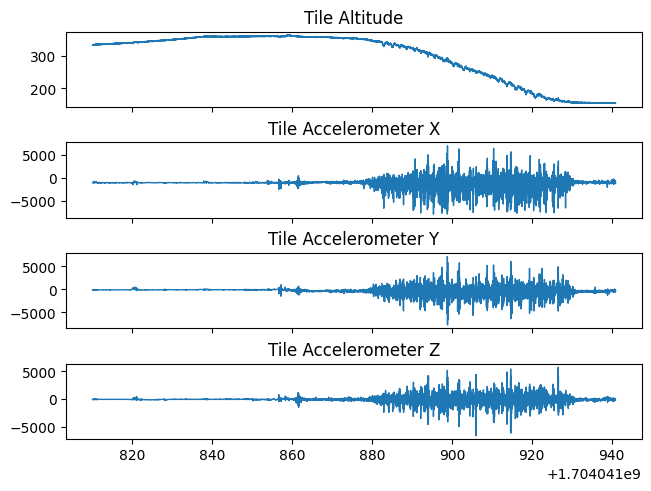

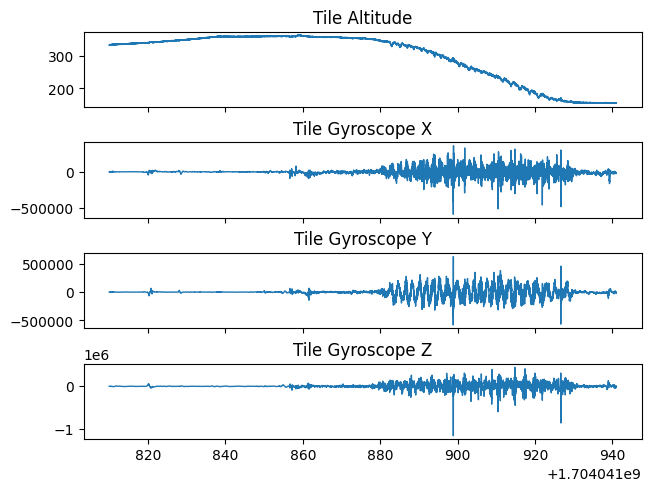

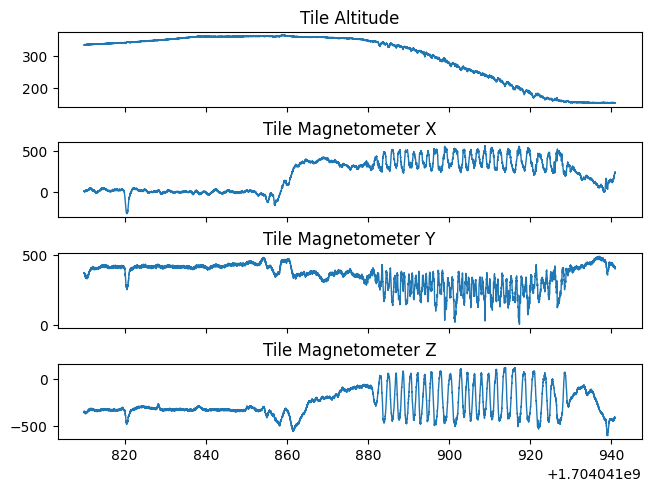

In [40]:
plotAltAcc(tile_runs[2])
plotAltGyr(tile_runs[2])
plotAltMag(tile_runs[2])